In [1]:
import numpy as np
import pandas as pd
import plotly.express as px 
import matplotlib.pyplot as plt
import seaborn as sns
import time
import requests
import datetime as dt
import plotly.graph_objects as go

In [30]:
df = pd.read_csv('./data_scrape.csv')
dfsub = pd.read_csv('./channel_stats.csv')

# Tổng quan

### Thống kê các thể loại chính của các nghệ sỹ từ 2012-nay

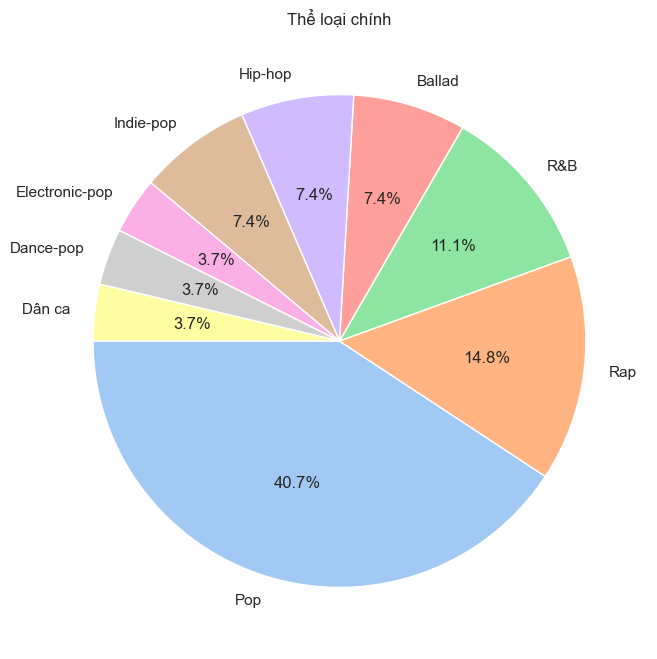

In [14]:
sns.set_theme(style="whitegrid")

plt.figure(figsize=(8, 8))
plt.pie(
    dfsub['Thể loại chính'].value_counts(), 
    labels=dfsub['Thể loại chính'].value_counts().index, 
    autopct='%1.1f%%', 
    startangle=180, 
    colors=sns.color_palette("pastel")[0:len(dfsub['Thể loại chính'].value_counts())]
)

plt.title("Thể loại chính")
plt.show()

### Network giữa các Tags xuất hiện trong Top 10 Videos nhiều Views nhất của tlinh, MCK // Nger & Pháo Northside

In [160]:
import ast

def fetchDf(channel):
    df_filtered = df[df["Tên kênh"].isin(channel)]

    # Lấy 10 videos có lượt view cao nhất từ mỗi kênh
    df_filtered = df_filtered.groupby("Tên kênh").apply(lambda x: x.nlargest(10, 'Số lượt xem')).reset_index(drop=True)

    # Lấy 10 tag đầu tiên từ mỗi video
    df_filtered["Tag"] = df_filtered["Tag"].apply(lambda x: x[:10] if isinstance(x, list) else [])

    # Chuyển đổi cột Tag thành danh sách nếu là chuỗi
    df_filtered["Tag"] = df_filtered["Tag"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

    df_filtered["Tag"] = df_filtered["Tag"].apply(lambda x: x if isinstance(x, list) else [])

    return df_filtered


In [165]:
import networkx as nx
from itertools import combinations
from collections import Counter

def networkPlot(channel):
    df_filtered = fetchDf(channel)
    # Tạo ma trận đồng xuất hiện
    co_occurrence = Counter()
    # Lấy tag của 30 video gần nhất của kênh
    for tags in df_filtered["Tag"]:
        for pair in combinations(sorted(tags), 2):
            co_occurrence[pair] += 1

    # Tạo đồ thị từ ma trận đồng xuất hiện
    G = nx.Graph()
    for (tag1, tag2), weight in co_occurrence.items():
        G.add_edge(tag1, tag2, weight=weight)


    plt.figure(figsize=(12, 12))

    # Sử dụng layout tránh đè các node
    pos = nx.spring_layout(G, k=0.3, iterations=50) 

    # Vẽ các node và cạnh
    nx.draw(
        G, pos, with_labels=True,
        node_size=1800, node_color="skyblue",
        font_size=10, font_color="black", edge_color="gray"
    )

    # Thêm nhãn trọng số trên các cạnh
    nx.draw_networkx_edge_labels(
        G, pos, edge_labels={(u, v): f"{d['weight']}" for u, v, d in G.edges(data=True)},
        font_size=8
    )

    plt.title("Network giữa các Tags của tlinh, MCK // Nger & Pháo Northside", fontsize=16)
    plt.show()


C:\Users\HP\AppData\Local\Temp\ipykernel_42900\2799793961.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filtered = df_filtered.groupby("Tên kênh").apply(lambda x: x.nlargest(10, 'Số lượt xem')).reset_index(drop=True)


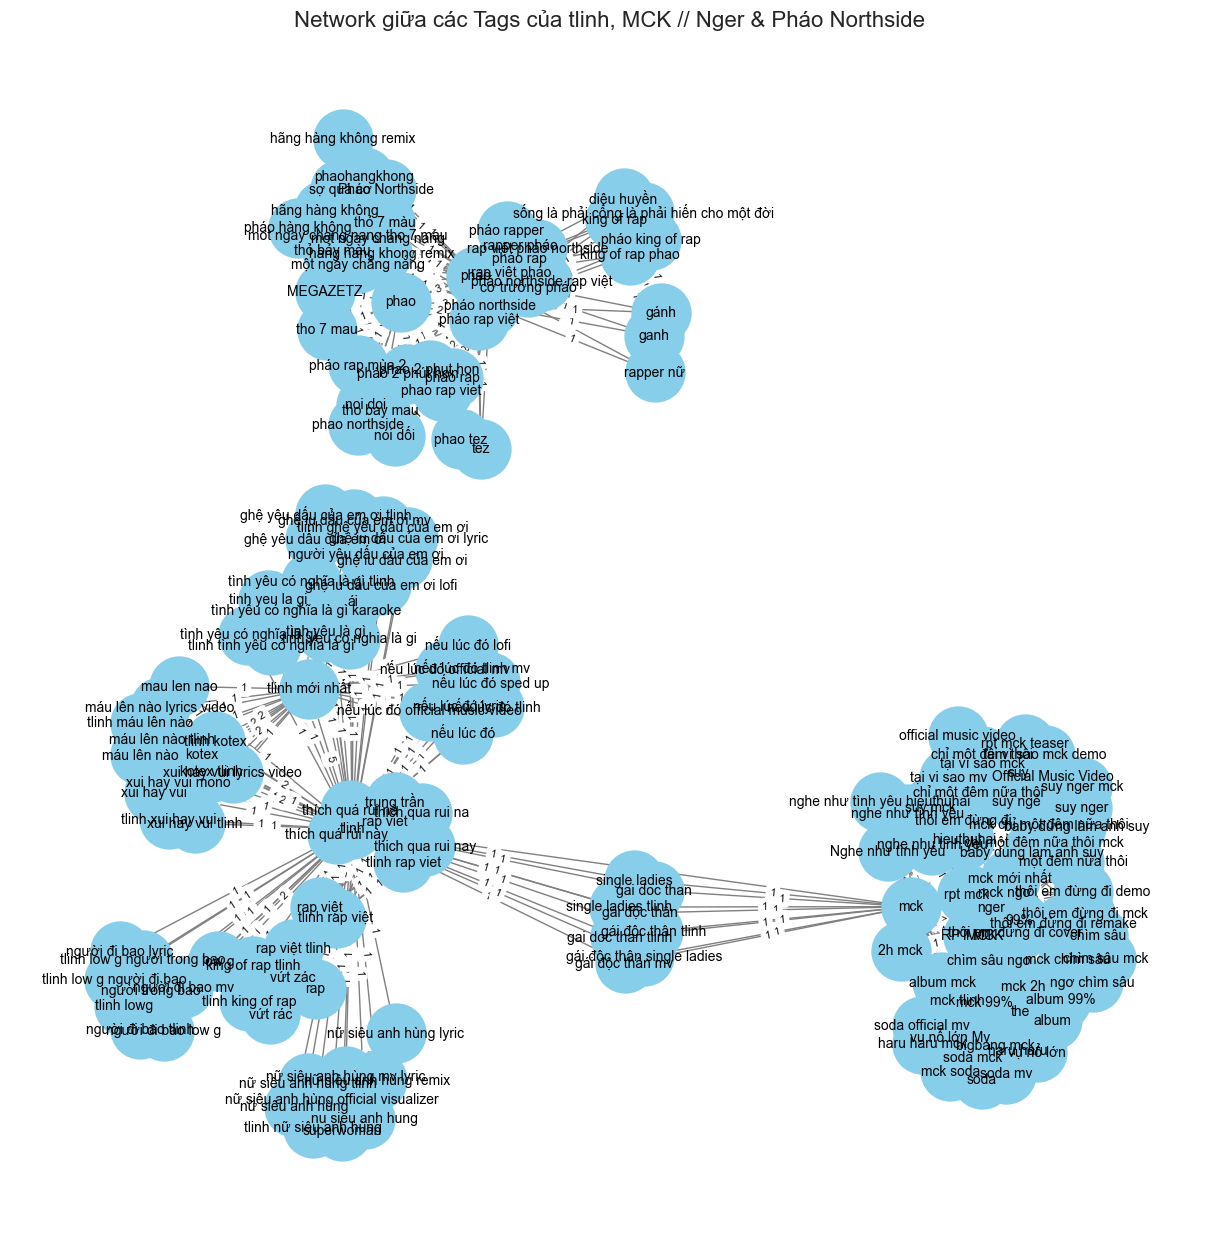

In [166]:
networkPlot(["tlinh", "MCK // Nger", "Pháo Northside"])

### Network giữa các video có lượt xem cao nhất của 27 nghệ sỹ dựa trên thời gian phát hành

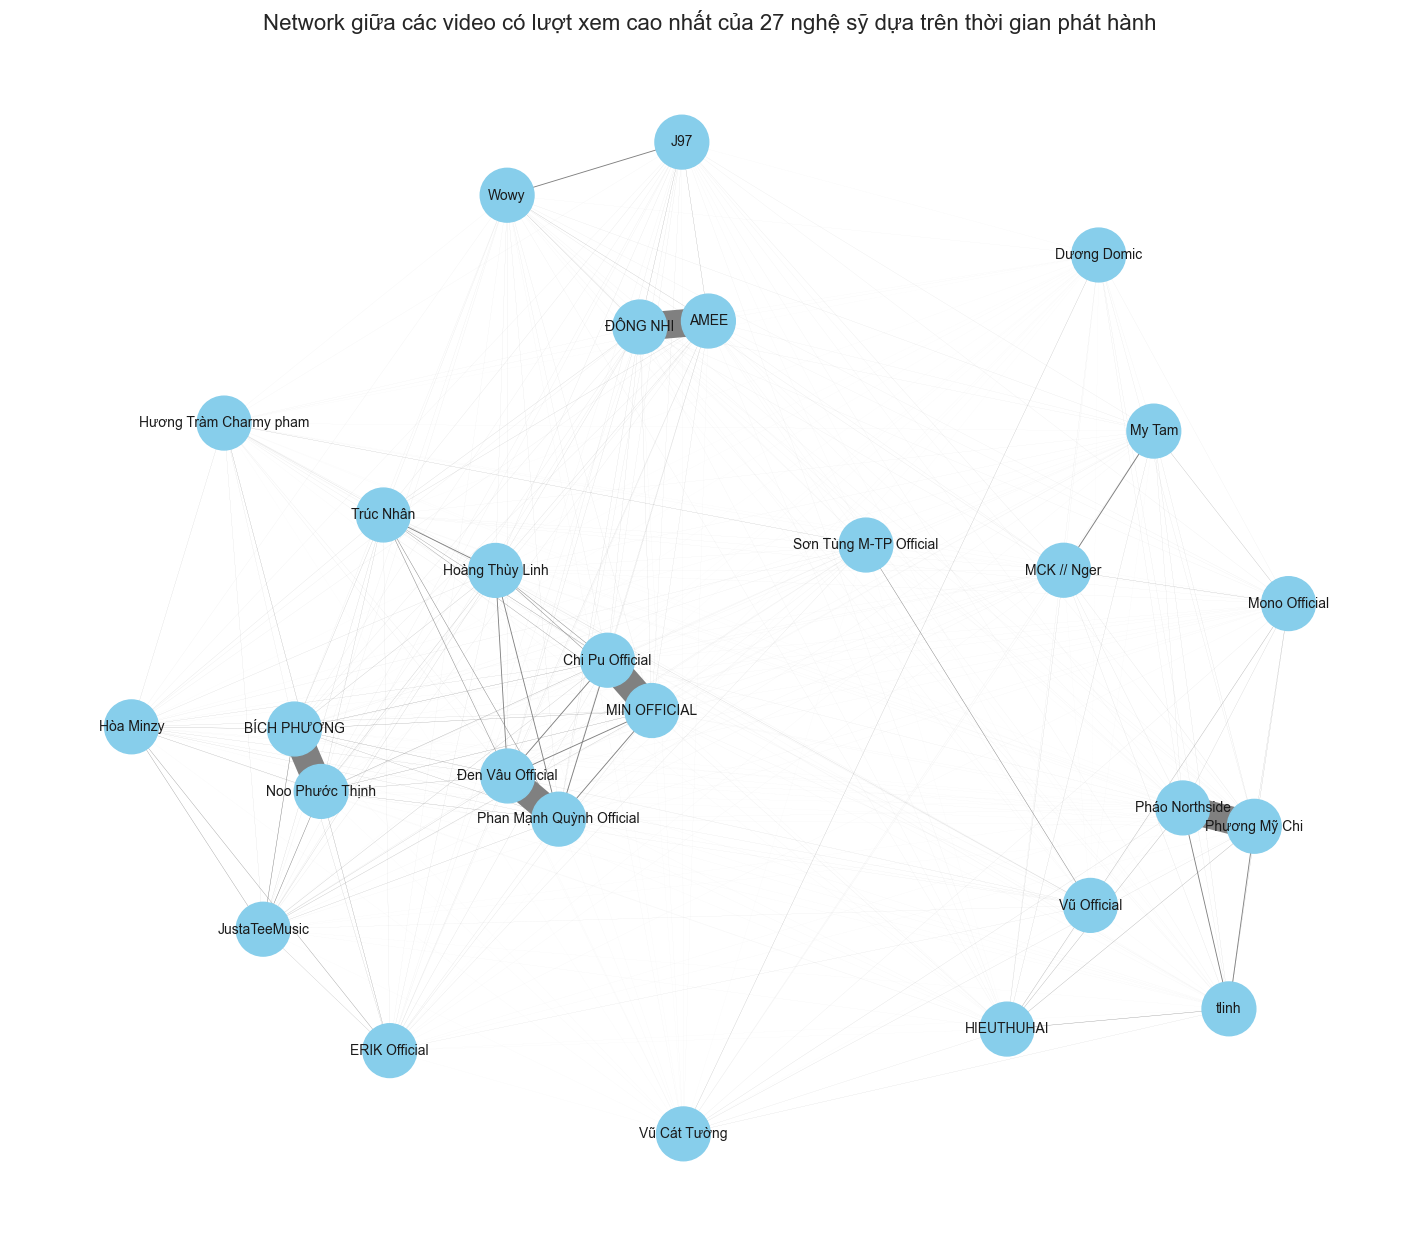

In [129]:
top_videos = df.loc[df.groupby("Tên kênh")["Số lượt xem"].idxmax()]

# Tạo ma trận trọng số
top_videos["Ngày phát hành"] = pd.to_datetime(top_videos["Ngày phát hành"])
video_ids = top_videos["Tên kênh"].tolist()
dates = top_videos["Ngày phát hành"].tolist()

# Tính trọng số giữa các video
n = len(video_ids)
weights = np.zeros((n, n))

for i in range(n):
    for j in range(n):
        if i != j:
            diff_days = abs((dates[i] - dates[j]).days)
            weights[i, j] = 1 / (1 + diff_days)

# Tạo đồ thị mạng
G = nx.Graph()

# Thêm các nút
for i, video in enumerate(video_ids):
    G.add_node(video, Nghesi=top_videos.iloc[i]["Tên kênh"])

# Thêm các cạnh và trọng số
for i in range(n):
    for j in range(i+1, n):
        if weights[i, j] > 0:
            G.add_edge(video_ids[i], video_ids[j], weight=weights[i, j])

pos = nx.spring_layout(G)
edges = G.edges(data=True)
weights = [edge[2]['weight'] for edge in edges]
weights = [w * 20 for w in weights]

plt.figure(figsize=(14, 12)) 

node_sizes = [1500 for _ in G.nodes()]  # Tăng kích thước node lên 1500

# Vẽ đồ thị
nx.draw(
    G,
    pos,
    with_labels=True,
    node_size=node_sizes,  
    node_color="skyblue",
    font_size=10,  
    width=weights,  
    edge_color="gray",  
)

plt.title("Network giữa các video có lượt xem cao nhất của 27 nghệ sỹ dựa trên thời gian phát hành", fontsize=16)
plt.show()


In [ ]:
top_videos

# Xu hướng thời gian hoạt động của các kênh

### Phân loại ngày đăng video theo thứ

In [133]:
df['Ngày phát hành'] = pd.to_datetime(df['Ngày phát hành'], errors='coerce')
df['Thứ'] = df['Ngày phát hành'].dt.day_name()

# Đếm số video theo ngày trong tuần
video_per_day_of_week = df.groupby('Thứ').size()

# Đảm bảo thứ tự ngày trong tuần là đúng
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
video_per_day_of_week = video_per_day_of_week.reindex(weekdays)
video_per_day_of_week


Thứ
Monday       628
Tuesday      547
Wednesday    642
Thursday     474
Friday       807
Saturday     555
Sunday       617
dtype: int64

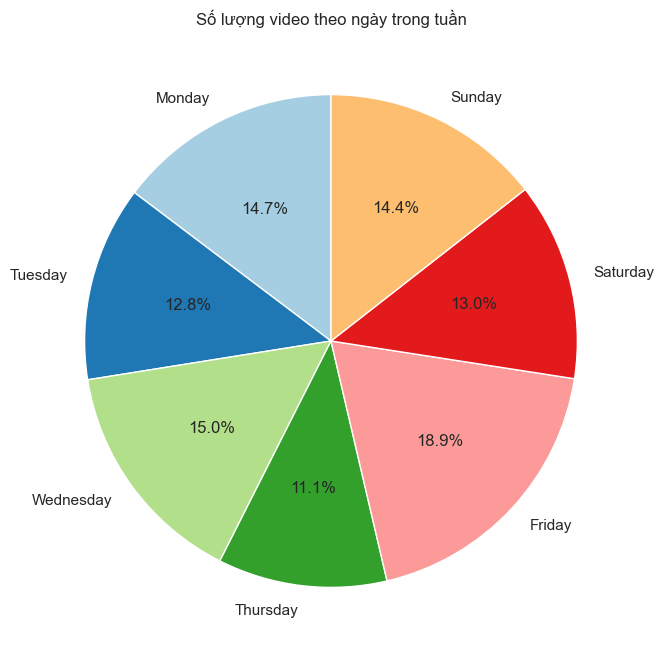

In [134]:
# Vẽ pie chart
plt.figure(figsize=(8, 8))
plt.pie(video_per_day_of_week, labels=video_per_day_of_week.index, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
plt.title("Số lượng video theo ngày trong tuần")
plt.show()